# Imports

In [1]:
from astropy.table import Table, Column, join, vstack
from astropy.io import fits
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky as match
import astropy.units as u
from astropy.cosmology import Planck18 #FlatLambdaCDM
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
from matplotlib.ticker import MaxNLocator
import pickle
import dill
import corner

import emcee

# import fsps
import lmfit
from lmfit import Model
from lmfit.models import GaussianModel, LorentzianModel, PolynomialModel, SplineModel, ExpressionModel
from scipy import interpolate

from astropy.stats import sigma_clip, sigma_clipped_stats
from scipy.integrate import quadrature as quad
from scipy.stats import norm
from scipy import interpolate
from scipy.optimize import minimize
from scipy.signal import medfilt
import numpy as np

import copy
# import re
# import h5py

# For galactic extinction
from dustmaps.config import config
config['data_dir'] = '/Users/meghanakilli/anaconda3/envs/jwst_spec/lib/python3.11/site-packages/dustmaps/data'
import dustmaps.planck
dustmaps.planck.fetch(which='GNILC')
from dustmaps.planck import PlanckGNILCQuery
planckgn = PlanckGNILCQuery()

import extinction
from dust_extinction.averages import G03_SMCBar # Rv = 2.74 - from documentation https://dust-extinction.readthedocs.io/en/stable/api/dust_extinction.averages.G03_SMCBar.html
calzatt = extinction.calzetti00
smcext = G03_SMCBar()

log = np.log10
c = 3e5 #km/s
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [12]:
# Correct the observed spectrum for extinction by the dust in the Milky Way (MW)

Rv = 3.1 #MW Rv

def galactic_ext_corr(wave_arr, flux_arr):
    # galactic extinction code from Clara
    # do this in observed frame because light has already been stretched by the time it gets to Milky Way
    # but no need to correct wavelength by *(1+z) because i'm passing observed wavelengths to the function later

    coords = SkyCoord(101.933406*u.deg, 70.198268*u.deg, frame='icrs')

    mw_ebv = planckgn(coords) # here you input the value for the field you are observing

    Av = Rv * mw_ebv
    pivot_wav = 1e4*wave_arr # here the wavelength of the filters you are using
    
    atten_mag = extinction.fm07(np.array(pivot_wav), Av)  # this is the extinction factor and you can choose different prescriptions, this one is Fitzpatrick & Massa 2007
    atten_factor = 10 ** (-0.4 * atten_mag)
    galactic_corrected = flux_arr*atten_factor# this is the final correction, multiply your fluxes by this factor to correct for galactic extinction
    
    return (galactic_corrected)

file = fits.open('jades-gdn-v1_prism-clear_1181_68797.spec.fits')
# file = fits.open('macsj0647-v1_prism-clear_1433_1045.spec.fits') # read in observed jwst prism fits spectrum
spec1d = Table(file[1].data) #get the 'SPEC1D' layer
wave = spec1d['wave'] #in microns (um)
flux = 0.3e-3*spec1d['flux']*c*(spec1d['wave']**-2) #in erg/s/cm^2/um; re-scale this to match photometry if you have it
galactic_ext_corr(wave, flux) # MW extinction corrected spectrum - correction is tiny

0.0
0.0
0.0
0.0
0.0
-1.0353784987817793
-0.9002212467303571
-0.4670734302994301
9.854799185062689
...
6.477903744554665


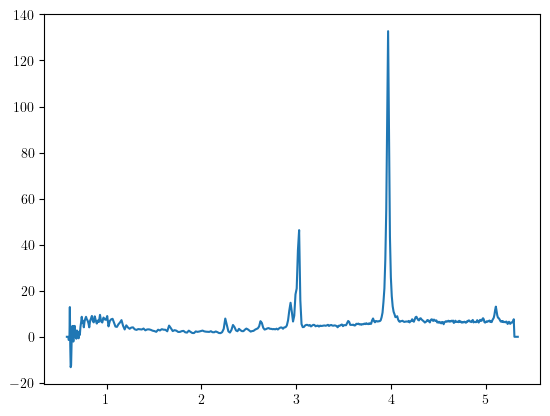

In [13]:
plt.plot(wave, flux)

# FSPS

In [3]:
def OH_to_Z(OH12): #Convert 12 + log(O/H) to Z
    OH12sun = 8.69 #+/- 0.05; Asplund2009
    Zsun = 0.0142 #Asplund2009
    Z = ( 10**(OH12 - OH12sun) ) * Zsun
    return Z
OH_to_Z(7.3)

0.0005784799944818405

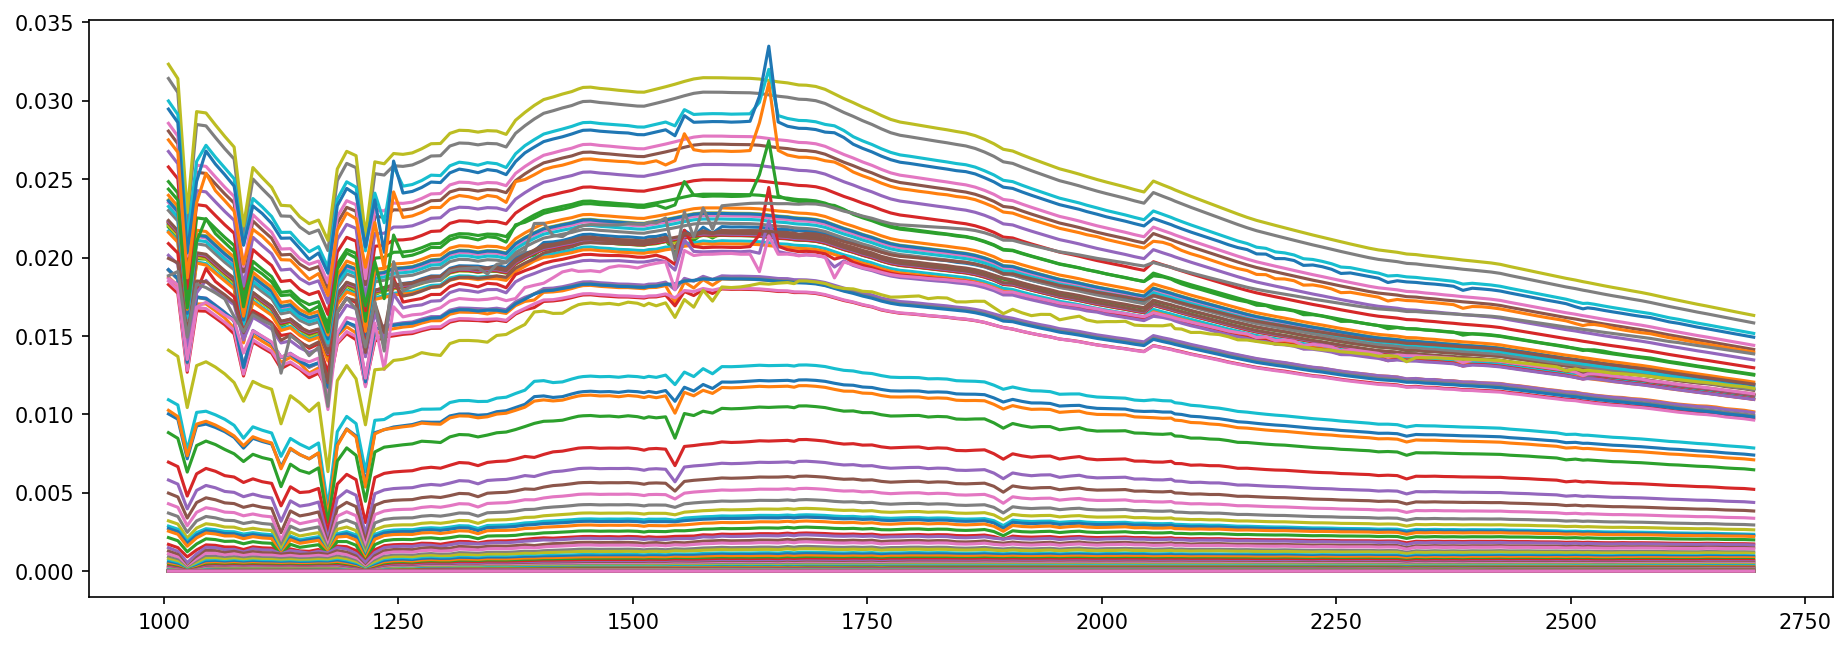

In [271]:
sp = fsps.StellarPopulation(add_neb_emission=False, imf_type=1, dust_type=5, dust1=0.01, dust2=0.5, dust_index=-0.5, dust1_index=-1.5, logzsol=-1.44, gas_logz=-1.44)
#, add_neb_continuum=True
#dust1 = optical depth for young stars; Tau(nu) = A(nu)/1.086
#dust2 = optical depth for all stars
#dust_type=2 => Calzetti - must use dust2 as it can only add dust equally to all stars
#dust1_index = power law slope for young stars
#dust_tesc - define how old a "young" star can be; log(years); default 7, ie 10Myrs

fig = plt.figure(figsize=(15,5), dpi=150)
specgrid = sp.get_spectrum(peraa=True)
wav = specgrid[0]
sel = (wav > 1000) & (wav < 2700)
for i in range(len(specgrid[1])):
    spec = specgrid[1][i]
    plt.plot(wav[sel],spec[sel])

(0.0, 130.0)

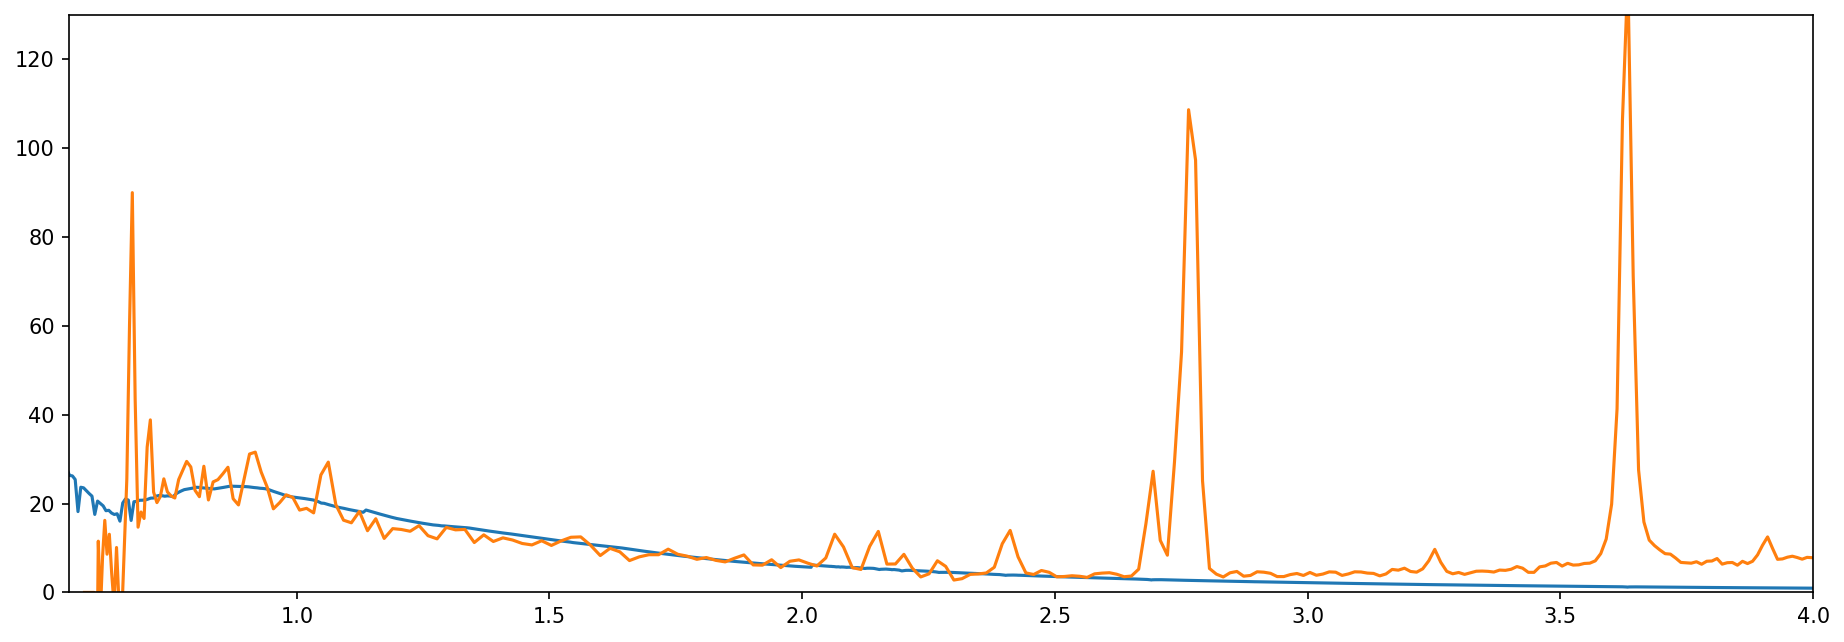

In [273]:
fig = plt.figure(figsize=(15,5), dpi=150)
sp = fsps.StellarPopulation(add_neb_emission=False, add_neb_continuum=False,
                            imf_type=1,
                            dust_type=5, dust1=0.01, dust2=0.5, dust_index=-0.5, dust1_index=-0.5,
                            logzsol=-1.44, gas_logz=-1.44)
wav, spec = sp.get_spectrum(tage=0.001, peraa=True)
wav = 1e-4*wav*(1+4.533)
sel = (wav > 0.5) & (wav < 5.5)
plt.plot(wav[sel], 1e3*spec[sel])
plt.plot(wave, flux)
plt.xlim(0.55,4)
plt.ylim(0,130)

In [179]:
wav

array([1.64467739e+05, 1.69889752e+05, 1.73504428e+05, ...,
       1.77426351e+11, 1.79071028e+11, 1.80733779e+11])

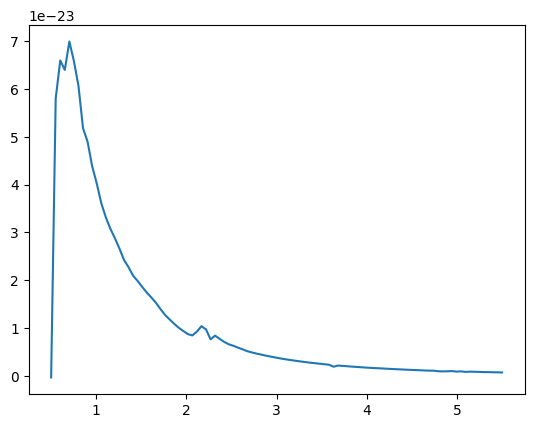

In [156]:
#This is slow, but it works - only way to make it faster is to fix age, but i don't think i can do that
def fsps_cont(x, norm, age, dust_opt):#, dust1_plslope=-1.5):
    x = 1e4 * x/(1+4.53) #get rest wavelength in angstroms
    sp = fsps.StellarPopulation(add_neb_emission=False, imf_type=1, dust_type=2, dust1=0.0, dust2=dust_opt)#, dust1_index=dust1_plslope)
    wave, spec = sp.get_spectrum(tage=age, peraa=True)
    f = interpolate.CubicSpline(wave, spec, bc_type='natural')
    spec_out = norm*f(x)
    return spec_out

xtest = np.linspace(0.5,5.5,100)
ytest = fsps_cont(xtest, age=0.05)
plt.plot(xtest,ytest)

In [175]:
sp = fsps.StellarPopulation(add_neb_emission=False, imf_type=1, dust_type=2, dust1=0.0, dust2=0.55)#, dust1_index=dust1_plslope)
wave, spec = sp.get_spectrum(tage=0.01, peraa=True)
f = interpolate.CubicSpline(wave, spec, bc_type='natural')

In [176]:
%%time
def fsps_cont(x, norm):#, dust1_plslope=-1.5):
    x = 1e4 * x/(1+4.53) #get rest wavelength in angstroms
    spec_out = norm*f(x)
    return spec_out
fsps_cont(xtest, 1)

CPU times: user 106 µs, sys: 1 µs, total: 107 µs
Wall time: 112 µs


array([0.00352536, 0.04635729, 0.0470749 , 0.02454618, 0.04487228,
       0.04028499, 0.03589322, 0.02921739, 0.02809618, 0.02487608,
       0.02221577, 0.01980154, 0.0177483 , 0.0161778 , 0.01468177,
       0.01330234, 0.01205498, 0.01098881, 0.01000807, 0.00921409,
       0.00845935, 0.00778163, 0.00717965, 0.00662054, 0.00608488,
       0.00560069, 0.00517982, 0.00479169, 0.00446643, 0.00415193,
       0.00389917, 0.00413205, 0.00395527, 0.00381979, 0.00357111,
       0.00322506, 0.00311831, 0.00291114, 0.0027198 , 0.00255386,
       0.00240752, 0.00226558, 0.00213756, 0.00201172, 0.00190346,
       0.00180179, 0.00171   , 0.00162248, 0.00154127, 0.00146464,
       0.00139275, 0.00132572, 0.00126253, 0.0012046 , 0.00114916,
       0.00109688, 0.0010475 , 0.00100056, 0.0009574 , 0.00091615,
       0.00087398, 0.00083717, 0.00077342, 0.00076926, 0.00073876,
       0.00070916, 0.00068084, 0.00065439, 0.00062936, 0.00060491,
       0.0005816 , 0.00055964, 0.00054177, 0.00052175, 0.00050

In [171]:
%%time
def fit_extinct_calz(x, A_v, norm, beta):
    wvrst = x/(1+4.53) #rest wavelengths
    wnrst = 1/wvrst #convert to wavenumbers in 1/microns rest-frame
    out = norm*(wnrst**(-beta))*(10**(-0.4*calzatt(wnrst, A_v, 4.05, unit='invum', out=None))) #fit power law and attenuation to rest wavenumbers
    # - should be 10**(-0.4*calzatt)!! calzatt returns Av magnitudes!!
    return out
fit_extinct_calz(xtest, 1, 1, 1)

CPU times: user 90 µs, sys: 1 µs, total: 91 µs
Wall time: 96.1 µs


array([0.00155544, 0.00317834, 0.00510453, 0.0071352 , 0.00917662,
       0.01120592, 0.01323406, 0.01528368, 0.0173788 , 0.0195408 ,
       0.02178743, 0.0241329 , 0.02658836, 0.02916248, 0.03186195,
       0.03469185, 0.037656  , 0.04075722, 0.04399748, 0.04737809,
       0.05089979, 0.05456289, 0.0583673 , 0.06231259, 0.06639809,
       0.07062289, 0.07498587, 0.07948577, 0.08412117, 0.08889055,
       0.09379228, 0.09882465, 0.10398589, 0.10927418, 0.11468764,
       0.12022436, 0.12588241, 0.13165984, 0.13755469, 0.143565  ,
       0.14968879, 0.15592411, 0.162269  , 0.16872151, 0.17527973,
       0.18194173, 0.18870562, 0.19556954, 0.20253163, 0.20959008,
       0.21674309, 0.22398887, 0.2313257 , 0.23875186, 0.24626566,
       0.25386543, 0.26154956, 0.26931645, 0.27716452, 0.28509223,
       0.29170144, 0.30001425, 0.30838337, 0.3168072 , 0.32528422,
       0.33381296, 0.342392  , 0.35101997, 0.35969553, 0.36841741,
       0.37718436, 0.38599521, 0.39484878, 0.40374398, 0.41267

# Make lmfit model

Make an lmfit model for the observed spectrum.

### Options for left and right continuum:

polynomial - 'polynomial' - i would start with this if you don't yet know anything about the continuum shape

set of splines - 'spline'

extinction (either SMC or Calzetti) corrected power law - 'calz_smc' or 'calz_calz' or 'smc_smc' or 'smc_calz'

### Additional options for right continuum:

blackbody (for emission from dust torus around AGN) - 'calz_bb' or 'smc_bb'

SMC extinction corrected blackbody - 'smc_smcbb' or 'calz_smcbb'

extinction corrected blackbody - 'smc_bb'

I also have FSPS galaxy model for left continuum, but it's waaay too slow, so commented out

### Options for lines:

All narrow lines - broad_lines=[]

Add broad components to some lines - broad_lines=['Ha','Hb']

Interacting galaxy with two sets of narrow lines - test='interacting' (also specify z1, z2, nwid1, nwid2, min_nwid1, min_nwid2, max_nwid1, max_nwid2


You can also use either Gaussian or Lorentz line profiles - line_model='gauss' or 'lorentz'

### Note:

You can turn on verbose=True, but it takes up a LOT of memory, and the notebook becomes very slow, so use with caution.

In [20]:
class model_spectrum:
    
    def __init__(self, filename='jades-gdn-v1_prism-clear_1181_68797.spec.fits',
                 verbose=False, redshift=5.0388, line_model='gauss',
                 wobs_range=(2.3,4.8), test='AGN', broad_lines=['Ha','Hb'], 
                 cont_model='calz_bb', scale_disp=1.3,
                 wid_narrow = 500, wid_broad = 3000, min_wid_narrow=100, max_wid_narrow=1000, min_wid_broad=500, max_wid_broad=5000, 
                 z1=5.035, z2=5.045, nwid1=500, nwid2=500, min_nwid1=100, max_nwid1=1000, min_nwid2=100, max_nwid2=1000):
        
        self.verbose = verbose
        if self.verbose:
            print('Going through model_spectrum __init__')
        
        file = fits.open(filename) #read in jwst prism fits spectrum
        self.spec1d = Table(file[1].data) #get the 'SPEC1D' layer
        sel0 = self.spec1d['flux'] > 0
        self.wave = self.spec1d['wave'][sel0] #microns
        flux = 0.3e-3*self.spec1d['flux'][sel0]*c*(self.spec1d['wave'][sel0]**-2) #sdss units but in microns instead of Angstroms (1e-17 erg cm^-2 s^-1 um^-1)
        self.flux = galactic_ext_corr(self.wave, flux) #MW extinction corrected spectrum
        self.ferr = 0.3e-3*self.spec1d['err'][sel0]*c*(self.spec1d['wave'][sel0]**-2) #rescaling flux error by the same factor as flux
        
        self.wobs_range = wobs_range #given range of wavelengths where we want the model to be created
        sel = (self.wave > wobs_range[0]) & (self.wave < wobs_range[1])
        self.wrange = self.wave[sel]
        self.frange = self.flux[sel]
        self.erange = self.ferr[sel]
        
        self.z = redshift #used to set the model wavelength range, and initial guess for single redshift model

        self.wrest_low = 1e4*wobs_range[0]/(1+self.z) #Angstrom; get rest wavelength for given observed wavelength
        self.wrest_high = 1e4*wobs_range[1]/(1+self.z) #Angstrom

        self.prism_res_tab = Table.read('jwst_nirspec_prism_disp.fits') #prism dispersion curve from jwst documentation
        self.scale_disp = scale_disp #scale factor to improve resolution - Gabe uses 1.3 for point sources - see Christensen, Jakobsen 2023
        
        self.ratios_tab = Table.read('lines_ratios.txt', format='ascii') #.txt file with line ratios to use for close doublets (from grizli utils.get_line_wavelengths)
        
        self.rest_lines = Table.read('lines_list.txt', format='ascii') #.txt file with list of line names and wavelengths (from grizli utils.get_line_wavelengths)
        indices = np.argwhere((self.rest_lines['wavelength(A)'] < self.wrest_high) & (self.rest_lines['wavelength(A)'] > self.wrest_low))
        ls = self.rest_lines['line'][indices] #line names
        ws = self.rest_lines['wavelength(A)'][indices] #rest wavelngths in Angstroms
        lbs = self.rest_lines['label'][indices] #Latex labels for plots
        self.rest_names = [elem[0] for elem in ls] #convert astropy column to list
        self.rest_waves = [elem[0] for elem in ws]
        self.rest_labels = [elem[0] for elem in lbs]
        
        self.test = test #save input options for easy access later
        self.line_model = line_model
        self.cont_model = cont_model
        
        if line_model == 'gauss': #use gaussian profile for lines
            self.mod = self.vw_gauss
        elif line_model == 'lorentz': #use lorentz profile
            self.mod = self.vw_lorentz
        
        if test == 'AGN': #model with broad lines
            self.model, self.params = self.make_agn_model(broad_lines=broad_lines,
                           cont_model=cont_model,
                           wid_narrow=wid_narrow, min_wid_narrow=min_wid_narrow, max_wid_narrow=max_wid_narrow,
                           wid_broad=wid_broad, min_wid_broad=min_wid_broad, max_wid_broad=max_wid_broad)
            
        elif test == 'interacting': #model with no broad lines
            self.model, self.params = self.make_interacting_model(cont_model=cont_model,
                                   z1=z1, z2=z2,
                                   nwid1=nwid1, min_nwid1=min_nwid1, max_nwid1=max_nwid1,
                                   nwid2=nwid2, min_nwid2=min_nwid2, max_nwid2=max_nwid2)
            
        if self.verbose:
            print('Done with model_spectrum __init__') 
        
    def plot_rest_spec(self, xlims=(1000, 9700), save=False):
    # Plot the rest spectrum and mark expected line positions and wavelengths
    # only for visualization; i have a better version if required

        if self.verbose:
            print('Plotting rest spectrum')

        x = 1e4*self.wave/(1+self.z) #convert to rest frame Angstrom
        y = self.flux*1e-4 #convert to 1e-17 erg cm^-2 s^-1 Angstrom^-1
        cs = ['red','green','blue','goldenrod','violet']
        
        waves_full = np.array(self.rest_lines['wavelength(A)'])
        sel = (waves_full > xlims[0]) & (waves_full < xlims[1])
        
        fig, ax = plt.subplots(figsize=(14,7),dpi=150)
        ax.plot(x, y, color='black')#, linestyle='None', marker='.')
        
        pchip = interpolate.PchipInterpolator(x, y)

        for i in range(len(self.rest_lines[sel])):
            if self.rest_lines[sel]['show'][i] == 0:
                continue
            xtxt = self.rest_lines[sel]['wavelength(A)'][i]
            ytxt = pchip(xtxt)
            ax.vlines(xtxt, ymin=(ytxt)+0.0010, ymax=ytxt+0.0014, linestyle='solid', color='darkviolet')
            llabel = self.rest_lines[sel]['label'][i]
            ax.text(xtxt, ytxt+0.0017, fr'{llabel}', rotation=90, horizontalalignment='center', color='darkviolet')

        plt.xlim(xlims[0], xlims[1])
        plt.ylim(bottom=0)

        ax.minorticks_on()
        plt.xlabel('rest wavelength (A)')
        plt.ylabel(r'$f_\lambda$ (10$^{-17}$ erg/s/cm$^2$/A)')
        
        if save:
            plt.savefig(f'plots/rest_spec_lines_{xlims[0]}_{xlims[1]}.pdf', format='pdf', dpi=200, pad_inches=0, bbox_inches='tight')
        
#         plt.show()

# Getting everything together for lmfit
        
    def lw_sig_um(self, vw, lam):
    # Calculate the sigma of line width (in microns) as the sum in quadrature of velocity width and minimum PRISM resolution
        if self.verbose:
            print('Convolving PRISM resoultion with given velocity width')

        pchip = interpolate.PchipInterpolator(self.prism_res_tab['WAVELENGTH'], self.prism_res_tab['R']) #turn the resolution table into a continuous function
        min_res = self.scale_disp*pchip(lam) #find resolution at given wavelength(s)
        del_lam = lam/min_res #resolution in microns (assuming res_tab has delta lambdas corresponding to fwhm, not sigma)
        vw_um = vw*lam/c #convert given real velocity width from km/s to microns
        lw = np.hypot(vw_um, del_lam) #expected fwhm of observed line for the given real velocity width
        lw_sigma = lw/2.355 #convert expected fwhm of convolved (line + resolution) to sigma (um)
        return lw_sigma

    def vw_lorentz(self, x, ht, mean, vw):
    # Make a gaussian model with variable velocity width, height, and mean
        if self.verbose:
            print('Making Lorentzian line model')

        lw = self.lw_sig_um(vw, mean) #sigma of line corresponding to given vel width
        # but i assumed gaussian so converted fwhm to sigma using 2.355; change to 2 for lorentzian
        sig = lw*2.355/2
        vw_lorentz_model = ht * (sig**2) / ((x - mean)**2 + sig**2) #A*sig*np.pi = height;
        #convert fwhm to vw, ht = 2A/fwhm*pi, fwhm = 2 sigma
        return vw_lorentz_model
    
    def vw_gauss(self, x, ht, mean, vw):
    # Make a gaussian model with variable velocity width, height, and mean
        if self.verbose:
            print('Making Gaussian line model')
        lw = self.lw_sig_um(vw, mean) #sigma of line corresponding to given vel width
        vw_gauss_model = ht * np.exp(-0.5 * ((x - mean)**2) / (lw**2))
        return vw_gauss_model
    
    def get_ratio(self, rat_tab, linename):
    # Get the line ratio from the text file
        if self.verbose:
            print('Getting line ratios from file')

        idx = np.argwhere(linename == self.ratios_tab['line'])
        base = self.ratios_tab['base'][idx][0][0]
        mult = self.ratios_tab['multiplier'][idx][0][0]
        return (base, mult)
    
# Fitting continuum
    
    def fit_extinct_calz(self, x, A_v, norm, beta): #make a Calzetti extinguished power law model
        #x is observed wavelength in microns
        wvrst = x/(1+self.z) #convert to rest wavelength
        wnrst = 1/wvrst #convert to wavenumbers in 1/microns rest-frame
        out = norm*(wnrst**(-beta))*(10**(-0.4*calzatt(wnrst, A_v, 4.05, unit='invum', out=None))) #fit power law and attenuation to rest wavenumbers
        # - should be 10**(-0.4*calzatt)!! calzatt returns Av magnitudes!!
        return out
    def fit_extinct_smc(self, x, A_v, norm, beta): # SMC extinguished power law model
        wvrst = x/(1+self.z) #rest wavelengths
        wnrst = 1/wvrst #convert to wavenumbers in 1/microns rest-frame
        out = norm*(wnrst**(-beta))*smcext.extinguish(wnrst, Av=A_v) #fit power law and attenuation to rest wavenumbers
        return out
    def fit_planck_bb(self, x, temp, norm): #make a Planck blackbody model
        wvrst = x/(1+self.z) #convert to rest-frame microns
        h = 6.6e-27 #erg-s
        c_cm = 3e10 #cm/s
        kB = 1.38e-16 #erg/K
        Blam = norm * ((1+self.z)**-4) * 1e12 * (2*h*(c_cm**2)/(wvrst**5)) / (np.exp(1e4*h*c_cm/(wvrst*kB*temp)) - 1) #fit black body at rest wavelengths
        #incl. cosmological surface brightness dimming
        return Blam #erg/s/cm^2/um/steradian
    def fit_extinct_bb(self, x, temp, norm, A_v): #SMC extinguished blackbody model
        wvrst = x/(1+self.z)
        wnrst = 1/wvrst
        h = 6.6e-27 #erg-s
        c_cm = 3e10 #cm/s
        kB = 1.38e-16 #erg/K
        Blam = norm * ((1+self.z)**-4) * 1e12 * ((2*h*(c_cm**2)/(wvrst**5)) / (np.exp(1e4*h*c_cm/(wvrst*kB*temp)) - 1)) * smcext.extinguish(wnrst, Av=A_v)
        # fit blackbody at rest wavelengths and attenuation at rest wavelengths
        return Blam #erg/s/cm^2/um/steradian

#     def fsps_cont(self, x, norm=1e-20, age=0.01, dust_opt=0.6/1.086):#, dust1_plslope=-1.5):
#         x = 1e4 * x/(1+self.z) #get rest wavelength in angstroms
#         sp = fsps.StellarPopulation(add_neb_emission=False, imf_type=1, dust_type=2, dust1=0.0, dust2=dust_opt)#, dust1_index=dust1_plslope)
#         wave, spec = sp.get_spectrum(tage=age, peraa=True)
#         f = interpolate.CubicSpline(wave, spec, bc_type='natural')
#         spec_out = norm*f(x)
#         return spec_out

    def make_continuum(self, cont_model='calz_bb'):
    # Make a continuum model - combinations of Calzetti, SMC, blackbody, extinguished blackbody
        if self.verbose:
            print(f'Fitting {cont_model} to continuum')
        
        if (cont_model == 'polynomial') or (cont_model == 'spline'):
            cmodel, cparams = self.fit_simple_continuum(self.wrange, self.frange, cont_model=cont_model, nsplines=10)
        
        else:
            lcont, rcont = cont_model.split('_')
            betamin = -3
            betamax = 0

#             if lcont == 'fsps': #SF galaxy
#                 lcmodel = Model(self.fsps_cont, prefix='l_')
#                 lcparams = lcmodel.make_params()
#                 lcparams['l_dust_opt'].set(0.55, min=0)#min=0.1
#                 lcparams['l_age'].set(0.01, min=0)
#                 lcparams['l_norm'].set(1e-17, min=0)
            if lcont == 'calz': #SF galaxy
                lcmodel = Model(self.fit_extinct_calz, prefix='l_')
                lcparams = lcmodel.make_params()
                lcparams['l_A_v'].set(0.8, min=0)#min=0.1
                lcparams['l_beta'].set(-2, min=betamin, max=betamax)
                lcparams['l_norm'].set(1.93, min=0)
            if lcont == 'smc': #AGN
                lcmodel = Model(self.fit_extinct_smc, prefix='l_')
                lcparams = lcmodel.make_params()
                lcparams['l_A_v'].set(0.6, min=0)
                lcparams['l_beta'].set(-2.9, min=betamin, max=betamax)
                lcparams['l_norm'].set(1, min=0)

            if rcont == 'bb': #AGN torus
                rcmodel = Model(self.fit_planck_bb, prefix='r_')
                rcparams = rcmodel.make_params()
                rcparams['r_temp'].set(2400, min=0)
                rcparams['r_norm'].set(0.3, min=0)
            if rcont == 'smc': #SF galaxy with attenuation
                rcmodel = Model(self.fit_extinct_smc, prefix='r_')
                rcparams = rcmodel.make_params()
                rcparams['r_A_v'].set(5, min=0)
                rcparams['r_beta'].set(-2.9, min=betamin, max=betamax)
                rcparams['r_norm'].set(45, min=0)
            if rcont == 'calz': #SF galaxy with attenuation
                rcmodel = Model(self.fit_extinct_calz, prefix='r_')
                rcparams = rcmodel.make_params()
                rcparams['r_A_v'].set(3, min=0)
                rcparams['r_beta'].set(-2, min=betamin, max=betamax)
                rcparams['r_norm'].set(1, min=0)
            if rcont == 'smcbb': #AGN torus with extinction from surrounding material
                rcmodel = Model(self.fit_extinct_bb, prefix='r_')
                rcparams = rcmodel.make_params()
                rcparams['r_temp'].set(2400, min=0)
                rcparams['r_A_v'].set(3, min=0)
                rcparams['r_norm'].set(0.3, min=0)

            cmodel = lcmodel+rcmodel
            cparams = lcparams+rcparams
                
        return(cmodel, cparams)

# The next three functions are to make polynomial or spline continuum models
    def get_cont_level(self, wavelength_array, flux_array, wavelength_position, sample_range=0.2):
    # Get continuum flux at given wavelength position
        if self.verbose:
            print('Estimating continuum flux')

        low = wavelength_position-sample_range/2  #Angstroms
        high = wavelength_position+sample_range/2  #Angstroms
        cont = sigma_clipped_stats(flux_array[np.argwhere((wavelength_array<high)&(wavelength_array>low))],sigma_upper=2)[1] #get the continuum flux, ie, median flux which is < 2 sigma, within the range
        return(cont)

    def masked_continuum(self, ws, fs):#, lwl = [0.65, 2.35, 2.6, 3.2, 3.57, 3.85, 4, 4.6, 5, 5.25], lwh = [0.75, 2.45, 2.81, 3.3, 3.75, 3.96, 4.1, 4.8, 5.18, 5.35]):
    # Return line-masked continuum flux across given observed wavelength range
        if self.verbose:
            print('Masking out lines')

        fmasked = copy.deepcopy(fs)
        for i in range(len(ws)):
            cont_level = self.get_cont_level(ws, fs, ws[i], sample_range=0.2)
            fmasked[i] = cont_level
        return(fmasked)

    def fit_simple_continuum(self, ws, fs, cont_model='polynomial', nsplines=10):
    # Fit the continuum with either a polynomial or spline
        if self.verbose:
            print(f'Fitting {cont_model} to continuum')

        fmasked = self.masked_continuum(ws, fs)
        
        if cont_model == 'polynomial':
            cmodel = PolynomialModel(degree=2)        
        if cont_model == 'spline':
            cmodel = SplineModel(xknots=np.array(np.linspace(self.wrange[0], self.wrange[-1], nsplines)))
        
        cparams = cmodel.guess(fmasked, ws) #automatically guess continuum model parameters

#         for p in cparams: # do not set constraints
#             cparams[p].set(min=cparams[p].value-10, max=cparams[p].value+10)
        
        return(cmodel, cparams)


# Making lmfit model
        
    def make_agn_model(self, broad_lines=['Ha'], cont_model='calz_bb', wid_narrow = 500, wid_broad = 3000,
                   min_wid_narrow=100, max_wid_narrow=1000, min_wid_broad=500, max_wid_broad=5000):
    # Make an lmfit model with broad lines (at the same redshift as narrow lines)
        if self.verbose:
            print('Making AGN model')
    
        cmodel, cparams = self.make_continuum(cont_model=cont_model) #get continuum model and parameters
        
        lines = self.rest_names #get line names and wavelengths in the given observed wavelength range
        rest_waves = self.rest_waves
        
        if len(broad_lines) < 1: #If there are no broad components to add
            broad = False
        else:
            broad = True
#             print(broad)
            if broad_lines[0] == 'all': #if broad components should be added to all lines
                rest_new = [rest_waves[lines.index(elem)] for elem in lines]
                lines += [f'{elem}broad' for elem in lines]
                rest_waves += rest_new
            elif len(set(broad_lines)) == len(broad_lines):                
                lines += [f'{elem}broad' for elem in broad_lines]
                rest_waves += [rest_waves[lines.index(elem)] for elem in broad_lines]
            else:
                seen = set()
                extra = [elem for elem in broad_lines if elem in seen or seen.add(elem)]
                lines += [f'{elem}broad' for elem in set(broad_lines)]
                lines += [f'{elem}extra' for elem in set(extra)]
                rest_waves += [rest_waves[lines.index(elem)] for elem in broad_lines]

        for i, l in enumerate(lines):
            if i == 0:
                lmodel = Model(self.mod, prefix=f'{l}_')
            else:
                lmodel += Model(self.mod, prefix=f'{l}_')
        
        zmin = self.z-0.01 #0.01 => z can go from 4.52 to 4.54
        zmax = self.z+0.01
        cens = [1e-4*elem*(1+self.z) for elem in rest_waves] #setting line centers in microns
        min_cens = [1e-4*elem*(1+zmin) for elem in rest_waves]
        max_cens = [1e-4*elem*(1+zmax) for elem in rest_waves]
        
        # create parameters for composite line model, but with default values:
        lparams = lmodel.make_params()
        
        model = cmodel + lmodel
        params = cparams + lparams
        
        for p in params:
            l_with_w = p.split('_')[0]
            
            if 'vw' in p:
                if ('broad' not in p) and ('extra' not in p):
                    params[p].set(wid_narrow, min=min_wid_narrow, max=max_wid_narrow) #set min and max for all narrow line velocity fwhms in km/s
#                     if l_with_w != lines[0]:
#                         params[p].set(expr=f'{lines[0]}_vw')
                    # tie all narrow widths to the first one in the list
                    if l_with_w != 'Ha':
                        params[p].set(expr='Ha_vw')
                    # tie all narrow widths to Ha
#                     if l_with_w == 'OIIw3727':
#                         params[p].set(expr='OIIw3729_vw')
#                     if l_with_w == 'CIIIw1906':
#                         params[p].set(expr='CIIIw1908_vw')
#                     if l_with_w == 'SIIIw9068':
#                         params[p].set(expr='SIIIw9531_vw')
#                     if l_with_w == 'OIIIw5007':
#                         params[p].set(expr='OIIIw4959_vw')
                    # tie doublet narrow widths together

                if broad == True:
                    if 'broad' in p:
                        params[p].set(wid_broad, min=min_wid_broad, max=max_wid_broad)
                        #set min for all broad line velocity fwhms in km/s; only use max to set upper limit on hb broad when checking if there is a broad line similar to ha
                        if l_with_w != 'Habroad':
                            params[p].set(expr='Habroad_vw')
                        # tie all broad vw to Habroad vw
#                         if l_with_w != 'OIIIw4959broad':
#                             params[p].set(expr='OIIIw4959broad_vw')
                        # tie all broad vw to OIIIw4959broad vw
#                         if l_with_w != 'Hbbroad':
#                             params[p].set(expr='Hbbroad_vw')
                        # tie all broad vw to Hb
#                         if l_with_w != lines[-1]:
#                            params[p].set(expr=f'{lines[-1]}_vw')
                        # tie all broad widths to the last one in the list; use this if fitting broad lines in region without Ha
#                         if l_with_w == 'OIIIw5007broad':
#                            params[p].set(expr='OIIIw4959broad_vw')
#                       # to fit broad component in Hb at the same width as that from Ha
                        

                    if 'extra' in p:
                        params[p].set(wid_broad, min=min_wid_narrow)#, max=max_wid_broad)
                        
                
            
            if 'ht' in p:
                spl = ['Lya', 'Hb', 'OIIIw4959', 'OIIIw5007', 'Ha', 'Habroad', 'HeIw7065']#, 'Yw2300','Yw3050']
                hspl = [65, 20, 35, 110, 106.75, 27.58, 5]#, -5, -5]
#                 lhspl = [40, 10, 25, 80, 70, 10, 3]
#                 hhspl = [100, 30, 50, 120, 130, 60, 8]
                if l_with_w in spl:
                    ht = hspl[spl.index(l_with_w)]
#                     min_ht = lhspl[spl.index(l_with_w)]
#                     max_ht = hhspl[spl.index(l_with_w)]
                else:
                    ht = 5
#                     min_ht = 0
#                     max_ht = 15
                    
                params[p].set(ht)
                if l_with_w.startswith('Y'):
                    params[p].set(max=0)
                else:
                    params[p].set(min=0)
#                 if l_with_w == 'Hg':
#                     params[p].set(9.043, max = 12.054, min = 8.2)
#                 params[p].set(hts[lines.index(l_with_w)], min=min_hts[lines.index(l_with_w)], max=max_hts[lines.index(l_with_w)])
                # does not include the numbers in combined line ratios (e.g.Ha+NII+SII+He) - should i include these?
                if l_with_w in self.ratios_tab['line']:
                    base, mult = self.get_ratio(self.ratios_tab, l_with_w)
                    if base in lines:
                        params[f'{p}'].set(expr=f'{base}_ht*{mult}')
                #if both lines are in the observed wavelength range, then set their height ratio
                if broad == True:
                    if ('broad' in p) or ('extra' in p):
                        if 'broad' in p:
                            be = 'broad'
                        elif 'extra' in p:
                            be = 'extra'
                        nwl = l_with_w.replace(be,'')
#                         if (broad_lines[0] == 'all') and (l_with_w != 'Habroad'): #if all lines need broad components, the fraction of broad/narrow height must be specified to reduce the number of free parameters
#                             params[p].set(expr=f'{nwl}_ht*Habroad_ht/Ha_ht')
                        if len(broad_lines) > 1: #if there are a few named lines that need broad components
                            if nwl in self.ratios_tab['line']:
                                base, mult = self.get_ratio(self.ratios_tab, nwl)
                                if f'{base}{be}' in lines:
                                    params[p].set(expr=f'{base}{be}_ht*{mult}') #if both base and line need a broad component, set the broad height ratio
            
            
            if 'mean' in p:
                if 'extra' in p:
                    mmin = min_cens[lines.index(l_with_w)]-0.05 #redshifted component 'extra'
                    mmax = max_cens[lines.index(l_with_w)]+0.05
                else:
                    mmin = min_cens[lines.index(l_with_w)]
                    mmax = max_cens[lines.index(l_with_w)]
                    
                nom_cen = cens[lines.index(l_with_w)]
                params[p].set(nom_cen, min=mmin, max=mmax)
#                 if 'broad' not in p:
#                     if (nom_cen < 3) and (l_with_w != 'Hb'): #to fit different zs on left and right side
#                         hbrest = rest_waves[lines.index('Hb')]
#                         params[p].set(expr=f'Hb_mean*{rest_waves[lines.index(l_with_w)]}/{hbrest}') #tie left wavelengths to Hb
#                     if (nom_cen >= 3) and (l_with_w != 'Ha'):
#                         harest = rest_waves[lines.index('Ha')]
#                         params[p].set(expr=f'Ha_mean*{rest_waves[lines.index(l_with_w)]}/{harest}') #tie right wavelengths to Ha

#                 if ('broad' not in p) and ('extra' not in p) and (l_with_w != lines[0]):
#                     params[p].set(expr=f'{lines[0]}_mean*{rest_waves[lines.index(l_with_w)]}/{rest_waves[0]}')
                # tie all narrow line wavelengths to the first one in the list - is it okay if first one is Lya? inaccurate z??
                if ('broad' not in p) and ('extra' not in p) and (l_with_w != 'Ha'):
                    params[p].set(expr=f'Ha_mean*{rest_waves[lines.index(l_with_w)]}/6564.697')
                # tie all narrow line means to Ha
#                 if ('broad' not in p) and ('extra' not in p) and (l_with_w != 'OIIIw4959'):
#                     params[p].set(expr=f'OIIIw4959_mean*{rest_waves[lines.index(l_with_w)]}/4960.295')
                # tie all narrow line wavelengths to OIIIw4959

                if broad == True:
                    if 'broad' in p:
                        nwp = p.replace('broad','')
                        params[p].set(expr=str(nwp))
                   # tie all broad line wavelengths to corresponding narrow line wavelengths - because it looks like ha broad and narrow have no offset
#                     if ('broad' in p) and (l_with_w != lines[-1]) and (l_with_w != 'Hbbroad'):
#                         params[p].set(expr=f'{lines[-1]}_mean*{rest_waves[lines.index(l_with_w)]}/{rest_waves[-1]}') #assuming last one in the list is a broad line
                   # tie all broad wavelengths together; don't tie them to corresponding narrow wavelengths to allow for narrow-broad offset; eg: from outflow
#                     if ('broad' in p) and (l_with_w != 'Habroad'):
#                         params[p].set(expr=f'Habroad_mean*{rest_waves[lines.index(l_with_w)]}/6564.697')
                   # tie all broad line means to Habroad
#                     if ('broad' in p) and (l_with_w == 'OIIIw4959broad'):
#                         params[p].set(expr=f'OIIIw5007broad_mean*{rest_waves[lines.index(l_with_w)]}/5008.239')
                   # tie broad oiiis together, but let broad Hb be free
#                     if ('extra' in p) and (l_with_w == 'OIIIw4959extra'):
#                         params[p].set(expr=f'OIIIw5007extra_mean*{rest_waves[lines.index(l_with_w)]}/5008.239')
                   # tie extra component mean to narrow mean

        return(model, params) #return the model and parameters

    def make_interacting_model(self, cont_model='calz_bb', z1=4.528, z2=4.537, nwid1=500, nwid2=500, min_nwid1=100, max_nwid1=1000, min_nwid2=100, max_nwid2=1000):
    # Make an lmfit model with two narrow components at different redshifts and velocity widths - increase max limit on vw??
        if self.verbose:
            print('Making interacting galaxy model')
        
        cmodel, cparams = self.make_continuum(cont_model=cont_model)
    
        lines = self.rest_names
        rest_waves = self.rest_waves
        
        lines1 = [f'One{elem}' for elem in lines]
        lines2 = [f'Two{elem}' for elem in lines]
        lines = lines1+lines2
        rest_waves += rest_waves
        zs = np.hstack((np.full(len(lines1),z1), np.full(len(lines2),z2)))

#         model = PolynomialModel(degree=2) #continuum #degree 1 => y = mx + c => c0 is the y intercept and c1 is the slope

        for i, l in enumerate(lines):
            if i == 0:
                lmodel = Model(self.mod, prefix=f'{l}_')
            else:
                lmodel += Model(self.mod, prefix=f'{l}_')

        cens = 1e-4*np.array(rest_waves)*(1+zs)
        min_cens = [elem-0.01 for elem in cens]
        max_cens = [elem+0.01 for elem in cens]

        # create parameters for composite model, but with default values:
        lparams = lmodel.make_params()
        
        model = cmodel + lmodel
        params = cparams + lparams

        for p in params:
            l_with_w = p.split('_')[0]
            if 'vw' in p:
                if 'One' in p:
                    params[p].set(nwid1, min=min_nwid1, max=max_nwid1) #set all left line velocity fwhms in km/s
                    if l_with_w != lines1[0]:
                        params[p].set(expr=f'{lines1[0]}_vw') #tie all left fwhms to left Ha width
                if 'Two' in p:
                    params[p].set(nwid2, min=min_nwid2, max=max_nwid2) #set all right line velocity fwhms in km/s
                    if l_with_w != lines2[0]:
                        params[p].set(expr=f'{lines2[0]}_vw') #tie all right fwhms to right Ha width

            if 'ht' in p:
                nonuml = l_with_w.replace('Two','')
                nonuml = nonuml.replace('One','')

                spl = ['Lya', 'Hb', 'OIIIw4959', 'OIIIw5007', 'Ha']
                hspl = [30, 5, 15, 30, 60]
#                 lhspl = [10, 1, 1, 10, 10]
#                 hhspl = [80, 30, 40, 90, 90]
                if nonuml in spl:
                    ht = hspl[spl.index(nonuml)]
#                     min_ht = lhspl[spl.index(nonuml)]
#                     max_ht = hhspl[spl.index(nonuml)]
                else:
                    ht = 5
#                     min_ht = 0.01
#                     max_ht = 15

                params[p].set(ht, min=0)#, max=max_ht)

                if nonuml in self.ratios_tab['line']:
                    base, mult = self.get_ratio(self.ratios_tab, nonuml)
                    if 'One' in p:
                        numbase = f'One{base}'
                        if numbase in lines:
                            params[p].set(expr=f'{numbase}_ht*{mult}')
                    if 'Two' in p:
                        numbase = f'Two{base}'
                        if numbase in lines:
                            params[p].set(expr=f'{numbase}_ht*{mult}')

            if 'mean' in p:
                params[p].set(cens[lines.index(l_with_w)], min=min_cens[lines.index(l_with_w)], max=max_cens[lines.index(l_with_w)])
                if (l_with_w != lines1[0]) and ('One' in p):
                    params[p].set(expr=f'{lines1[0]}_mean*{rest_waves[lines.index(l_with_w)]}/{rest_waves[0]}')
                if (l_with_w != lines2[0]) and ('Two' in p):
                    params[p].set(expr=f'{lines2[0]}_mean*{rest_waves[lines.index(l_with_w)]}/{rest_waves[0]}')

        return(model, params)

In [31]:
spec = model_spectrum(filename='jades-gdn-v1_prism-clear_1181_68797.spec.fits',
                      wobs_range=(3.8,4.2), scale_disp=1.3,#min_wid_narrow=896.2924-18.7, max_wid_narrow=896.2924+87,
                      broad_lines=['Ha'], cont_model='polynomial')
# np.where(spec.model.eval(spec.params, x=spec.wrange) < 0)
# xarr = np.linspace(1.8,2.6,100)
init = spec.model.eval(params=spec.params, x=spec.wrange)
spec.params#.lw_sig_um(300, 9071)*2.335*c/9071

name,value,initial value,min,max,vary,expression
c0,-614.241539,None,-inf,inf,True,
c1,311.817029,None,-inf,inf,True,
c2,-39.0886156,None,-inf,inf,True,
NIIw6549_ht,5.00000000,None,0.00000000,inf,True,
NIIw6549_mean,3.95532946,None,3.94877960,3.96187932,False,Ha_mean*6549.86/6564.697
NIIw6549_vw,500.000000,None,100.000000,1000.00000,False,Ha_vw
Ha_ht,106.750000,None,0.00000000,inf,True,
Ha_mean,3.96428922,None,3.95772453,3.97085392,True,
Ha_vw,500.000000,None,100.000000,1000.00000,True,
NIIw6585_ht,15.0000000,None,0.00000000,inf,False,NIIw6549_ht*3.0


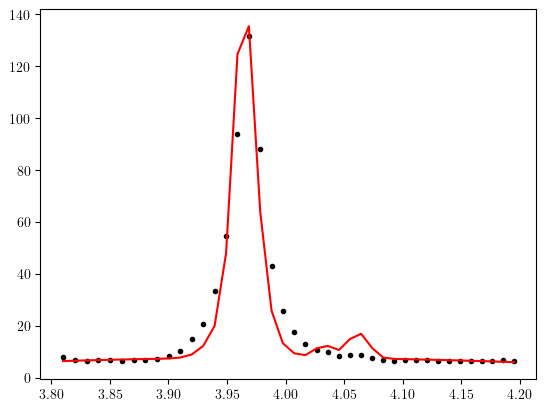

In [32]:
# Check whether the model approximately looks like the observed spectrum.
# If not, modify the initial parameters until there is a decent match

plt.plot(spec.wrange, spec.frange, color='black', ls='None', marker='.')
plt.plot(spec.wrange, init, color='red')

# Fit lmfit model

Fit the model created above to the observed spectrum.

Option to re-scale JWST uncertainties, assuming that the model is a good approximation - probably can skip this if using MCMC later

In [24]:
class fit_spectrum(model_spectrum):
# Fits the model produced by model_spectrum
    def __init__(self, filename='jades-gdn-v1_prism-clear_1181_68797.spec.fits',
                 redshift=5.0388, wobs_range=(2.3, 4.8),
                 line_model='gauss', test='AGN', broad_lines=['Ha','Hb'],
                 cont_model='polynomial', scale_disp=1.3,
                 wid_narrow = 500, min_wid_narrow=100, max_wid_narrow=1000,
                 wid_broad = 3500, min_wid_broad=500, max_wid_broad=5000,
                 z1=5.035, z2=5.045,
                 nwid1=500, min_nwid1=100, max_nwid1=1000,
                 nwid2=500, min_nwid2=100, max_nwid2=1000,
                 wranges_list=[(0.6,1.1),(2,2.5),(2.6,2.85),(3.2,3.5),(3.55,3.72),(3.8,4.1),(4.6,5.3)], #for zoom-in plots
                 scale_errors=False, save=True, verbose=False):
        
        self.verbose = verbose

        if self.verbose:
            print('Going through fit __init__')
        
        super().__init__(filename=filename, verbose=verbose, redshift=redshift, wobs_range=wobs_range,
                         line_model=line_model, test=test, broad_lines=broad_lines, 
                         cont_model=cont_model, scale_disp=scale_disp,
                         wid_narrow=wid_narrow, min_wid_narrow=min_wid_narrow, max_wid_narrow=max_wid_narrow,
                         wid_broad=wid_broad, min_wid_broad=min_wid_broad, max_wid_broad=max_wid_broad,
                         z1=z1, z2=z2,
                         nwid1=nwid1, min_nwid1=min_nwid1, max_nwid1=max_nwid1,
                         nwid2=nwid2, min_nwid2=min_nwid2, max_nwid2=max_nwid2) #inherit all attributes and methods from model_spec

        self.wranges_list = self.get_relevant_zoom(wranges_list)
        
        self.result, self.uscale = self.fit_model(scale_errors=scale_errors) #Nelder fit result and uncertainty scaling
                        
        if save:
            broadls = ''
            if len(broad_lines) > 0:
                self.broadls = '_'.join(broad_lines)
            else:
                self.broadls = ''
            self.save = f'{test}_{cont_model}_{self.broadls}_{wobs_range[0]}_{wobs_range[1]}_{int(scale_errors)}'
        else:
            self.save = 'None'
        
        self.fit_plot = self.plot_fit_spec(self.result, scaling=self.uscale) #only plot Nelder fit to spectrum
        
        if save:
            self.save_self()
            
        if self.verbose:
            print('Done with fit __init__')

    def save_self(self):
        if self.verbose:
            print('Saving self to file')

        file = open(f'Simone_galaxy_{self.save}_self','wb')
        dill.dump(self, file)
        file.close()
              
    def get_relevant_zoom(self, wranges_list):
    # Get only the zoom-in plot ranges within given observed wavelength range
        if self.verbose:
            print('Getting relevant zoom-in plot ranges')

        new_wranges = [elem for elem in wranges_list if (elem[0] > self.wobs_range[0]) & (elem[1] < self.wobs_range[1])]        
        return(new_wranges)

# lmfit fitting

    def fit_model(self, scale_errors=True):
        if self.verbose:
            print('Fitting with lmfit')
        
        def scaled_result(res):
            if self.verbose:
                print('Scaling uncertainties')

        # Scale the (incorrect) JWST uncertainties so that reduced chisquared is 1
            def calc_uncertainty_scale(spec, spl, method='bfgs', order=3, init=(1, 3), **kwargs):
            # Function from Gabe's msaexp, slightly modified
                if self.verbose:
                    print('Calculating uncertainty scaling')

                ok = (spec['err'] > 0) & (spec['flux'] != 0) & np.isfinite(spec['err']+spec['flux'])

                if init is not None:
                    err = init[0]*spec['err']
                    err = np.sqrt(err**2 + (0.02*spec['flux'])**2)
                    _Ax = spl/err
                    _yx = spec['flux']/err
                    _x = np.linalg.lstsq(_Ax[:,ok].T, _yx[ok], rcond=None)
                    _model = spl.T.dot(_x[0])
                    ok &= np.abs((spec['flux']-_model)/err) < init[1]

                def objfun_scale_uncertainties(c):

                    err = 10**np.polyval(c, spec['wave'])*spec['err']
                    err = np.sqrt(err**2 + (0.02*spec['flux'])**2)

                    _Ax = spl/err
                    _yx = spec['flux']/err
                    _x = np.linalg.lstsq(_Ax[:,ok].T, _yx[ok], rcond=None)
                    _model = spl.T.dot(_x[0])

                    lnp = norm.logpdf((spec['flux']-_model)[ok],
                                      loc=_model[ok]*0.,
                                      scale=err[ok]).sum()    
                    return -lnp/2.

                c0 = np.zeros(order+1)

                res = minimize(objfun_scale_uncertainties, c0, method=method)

                return spec, 10**np.polyval(res.x, spec['wave']), res

            def get_uscale(wave, flux, ferr, temps):
            # Format input correctly for calc_uncertainty_scale, and get the scale factor array to multiply with uncertainty array
                if self.verbose:
                    print('Getting scaled uncertainties')

                tab = Table()
                tab.add_columns([wave, flux, ferr])#, names = ['wave','flux','err'])
                _,scl,_ = calc_uncertainty_scale(tab, temps)
                return scl
            
            xarr = np.linspace(self.wrange.min(),self.wrange.max(),len(self.wrange))
            comps = res.eval_components(x=xarr)
            comp_list = list(comps.items())
            comp_arrs = []
            for elem in comp_list:
                comp_arrs.append(elem[1])
            temps = np.array(comp_arrs)
            uscale = get_uscale(self.wrange, self.frange, self.erange, temps)            
            res_scaled = self.model.fit(self.frange, self.params, x=self.wrange, weights=1/(self.erange*uscale))
            return (uscale, res_scaled)

        if self.verbose:
            print('Started lmfit fitting')
        result = self.model.fit(self.frange, self.params, x=self.wrange, weights=1/self.erange)#, nan_policy='omit')#, method='Nelder') #, fit_kws={'ftol': 1e-07}
        # default fit tolerance is 1e-8; setting to 1e-7 hoping it will quit fitting faster
        if self.verbose:
            print('Finished lmfit fitting')

        if scale_errors:
            scaling, result = scaled_result(result)
        else:
            scaling = 1 #doubling JWST errors - why 2? idk, just random - from Darach
#         print(result.fit_report())
        
        return(result, scaling)

# Plotting

    def zoom_in_plots(self, dill_file_name, xarr, yarr, scl):
    # Make zoomed in plots from given dilled figure and wavelength ranges - check why y axis does not go down low enough to see NII and SII components in Ha complex fit
        if self.verbose:
            print('Making zoom-in plots')

        nfigs = len(self.wranges_list)
        for i in range(nfigs):
            axs = dill.load(open(dill_file_name,'rb'))
            wlow, whigh = self.wranges_list[i]
            
            axs[0].set_xlim(wlow,whigh)
            
            args = np.where((self.wrange > wlow) & (self.wrange < whigh)) #len = len(data)
            args_smooth = np.where((xarr > wlow) & (xarr < whigh)) #len = len(xarr) = 10*len(data)
            
            if type(scl) == int:
                scl = scl
            else:
                scl = np.max(scl[args])
            yhigh = max(np.max(yarr[args_smooth]), np.max(self.frange[args])+np.max(self.erange[args])*scl) #use the higher of fit and data+error for plot range
            
            axs[0].set_ylabel(r'$f_\lambda$', fontsize=18)
            axs[0].set_ylim(-1,yhigh)
            axs[0].get_legend().remove()
            
            if self.save is not None:
                plt.savefig(f'plots/{self.save}_zoom_{wlow}_{whigh}.pdf', format='pdf', dpi=200, pad_inches=0, bbox_inches='tight')
            plt.show()
    

    def plot_fit_spec(self, res, scaling=1):
    # Plot the fit spectrum with all its components
        if self.verbose:
            print('Making fit plot')

        xarr = np.linspace(self.wrange.min(),self.wrange.max(),len(self.wrange)*10)
        yarr = res.eval(x=xarr)
        comps = res.eval_components(x=xarr)
        ymod = res.eval(x=self.wrange)
        
        fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]}, figsize=(10,7), dpi=150)
        fig.subplots_adjust(hspace=0)
        
        ydat = self.frange
        yerror = self.erange*scaling
        axs[0].step(self.wrange, ydat, where='mid', color='blue', label='Data')#, linestyle='None', marker='.'
        axs[0].errorbar(self.wrange, ydat, yerr=yerror, color='blue', linestyle='None')
        axs[0].plot(xarr, yarr, linestyle='dashed', c='black', label='Total fit')   

        for comp in comps:
            l = comp.split('_')[0]
            if l in self.rest_names:
                if 'broad' in l:
                    arg = self.rest_names.index(l.replace('broad',''))
                    wlen = self.rest_waves[arg]
                    label = fr'{self.rest_labels[arg]}$_\mathrm{{broad}}$\,{wlen:.2f}'
                elif 'extra' in l:
                    arg = self.rest_names.index(l.replace('extra',''))
                    wlen = self.rest_waves[arg]
                    label = fr'{self.rest_labels[arg]}$_\mathrm{{extra}}$\,{wlen:.2f}'
                else:
                    arg = self.rest_names.index(l)
                    wlen = self.rest_waves[arg]
                    label = fr'{self.rest_labels[arg]}\,{wlen:.2f}'
            elif 'One' in l:
#                 print(l)
                arg = self.rest_names.index(l.replace('One',''))
                wlen = self.rest_waves[arg]
                label = fr'{self.rest_labels[arg]}$_1${wlen:.2f}'
#                 print(label)
            elif 'Two' in l:
                arg = self.rest_names.index(l.replace('Two',''))
                wlen = self.rest_waves[arg]
                label = fr'{self.rest_labels[arg]}$_2${wlen:.2f}'

            elif l == 'l':
                label = r'Continuum$_\mathrm{UV}$'
            elif l == 'r':
                label = r'Continuum$_\mathrm{NIR}$'
            else:
                label = l
            axs[0].plot(xarr, comps[comp], label=label)

        axs[0].set_ylabel(r'$f_\lambda$ (10$^{-17}$ erg/s/cm$^2$/$\rm\mu$m)', fontsize=18)
#         axs[0].set_ylim(bottom=-0)
        axs[0].tick_params(axis='y', labelsize=18)
        axs[0].yaxis.set_major_locator(MaxNLocator(prune='lower'))

#         axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.675), fancybox=True, ncol=6)
        axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, ncol=6)
        
        yresid = ydat-ymod
#         axs[1].step(self.wrange, yresid, where='mid', color='skyblue')
#         axs[1].errorbar(self.wrange, yresid, yerr=yerror, ls='', color='skyblue')
#         axs[1].axhline(0,ls='--', color='grey')
#         axs[1].set_ylim(-10,10)
#         axs[1].set_ylabel('Residual', fontsize=18)#\n(Data $-$ Model)

        ychi = yresid/yerror
        axs[1].step(self.wrange, ychi, where='mid', color='skyblue')
        axs[1].errorbar(self.wrange, ychi, yerr=np.ones_like(yerror),ls='', color='skyblue')
        axs[1].axhline(0,ls='--', color='grey')
        axs[1].set_ylabel(r'$\chi$', fontsize=18)
        axs[1].tick_params(axis='both', labelsize=18)

        plt.xlabel(r'$\lambda_\mathrm{obs}\,$($\rm\mu$m)', fontsize=18)
        
        if self.save is not None:
            plt.savefig(f'plots/{self.save}_fig.pdf', format='pdf', dpi=200, pad_inches=0, bbox_inches='tight')

#         file = open(f'plots/{self.save}_dill','wb')
#         dill.dump(axs, file)
#         self.zoom_in_plots(f'plots/{self.save}_dill', xarr, yarr, scaling)
#         file.close()
        
        return(fig)

# Test fit function

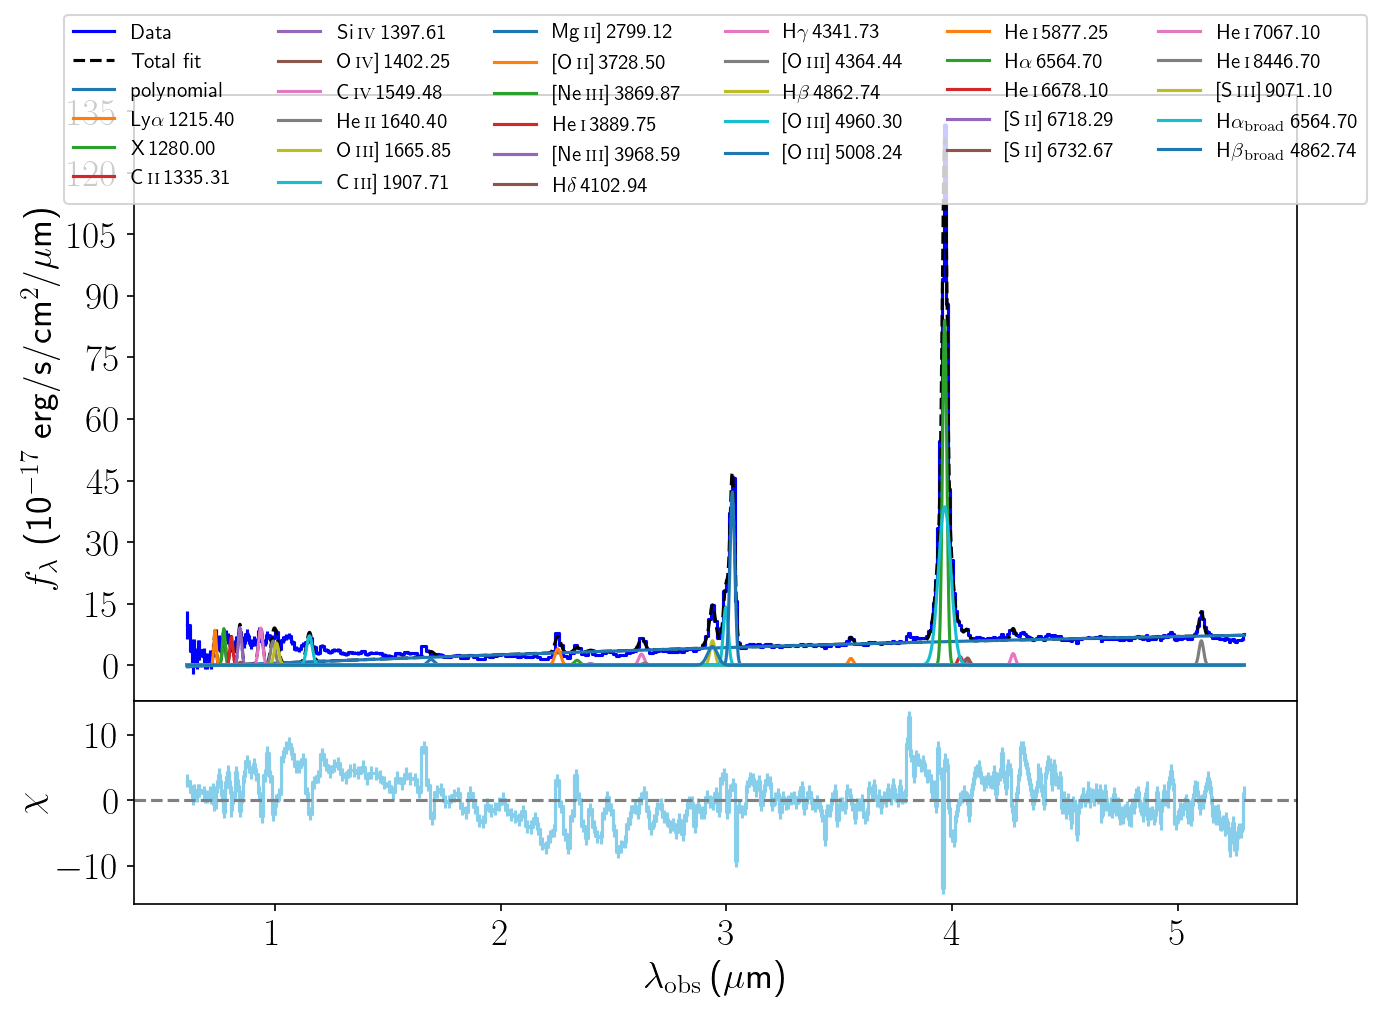

In [25]:
test = fit_spectrum(wobs_range=(0.5,5.5), scale_disp=1.3,
                    wid_narrow = 500, min_wid_narrow=100, max_wid_narrow=10000,
                    wid_broad = 4500, min_wid_broad=1000, max_wid_broad=10000,
                    broad_lines=['Ha','Hb'], cont_model='polynomial',
                    scale_errors=False, verbose=False, save=True)

In [14]:
test.result

In [237]:
test.rest_names

['NIIw6549', 'Ha', 'NIIw6585', 'HeIw6678', 'SIIw6717', 'SIIw6731']

In [68]:
# Get the redshift from the fit using Ha line

znarrow = 1e4*3.63106520/6564.697 - 1
zbroad = 1e4*3.63106520/6564.697 - 1
# zbroad = 1e4*4.67022882/8446.7 - 1
znarrow, zbroad

(4.5311999929318905, 4.5311999929318905)

In [27]:
# Try a different fit
testy = fit_spectrum(wobs_range=(0.5,5.5), scale_disp=1.3,
                    wid_narrow = 500, min_wid_narrow=100, max_wid_narrow=10000,
                    wid_broad = 4357.8, min_wid_broad=1000, max_wid_broad=10000,
                    broad_lines=['Ha','Hb'], cont_model='calz_calz',
                    scale_errors=False, verbose=False, save=True)

KeyboardInterrupt: 

In [118]:
testy.result
# print(testy.result.fit_report())

In [251]:
znarrow = 1e4*2.69000217/4862.738 - 1
zbroad = 1e4*2.69327461/4862.738 - 1
zo4broad = 1e4*2.75345975/4960.295 - 1
zo5broad = 1e4*2.78007347/5008.239 - 1
znarrow, zbroad, zo4broad, zo5broad

(4.531867375951573, 4.538597000290783, 4.550999990927959, 4.551000002196381)

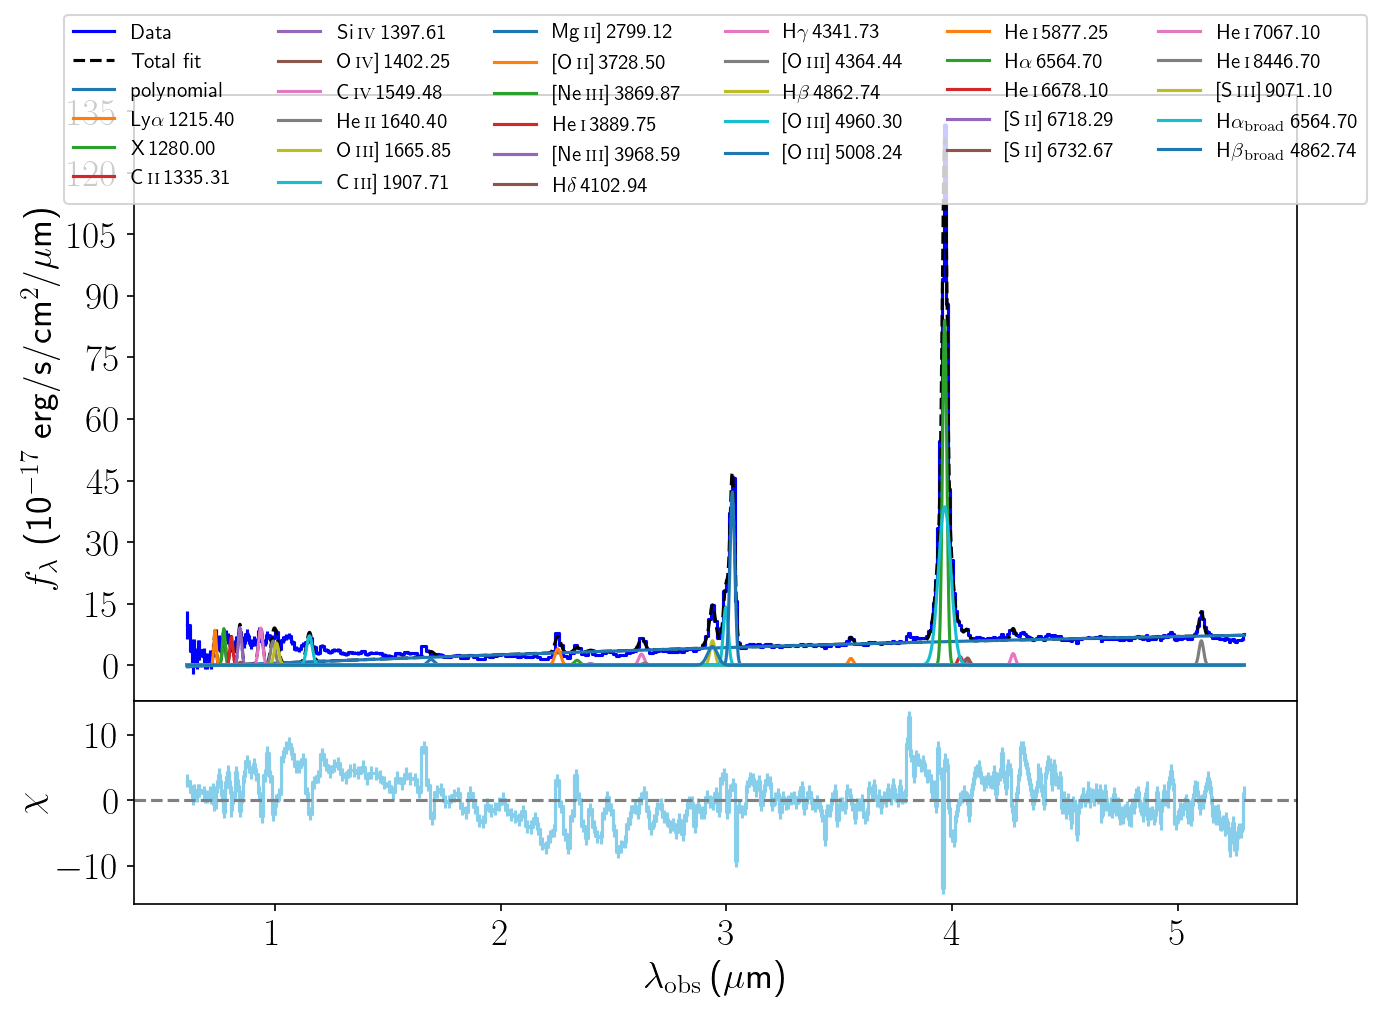

In [26]:
fitnew = dill.load(open('Simone_galaxy_AGN_polynomial_Ha_Hb_0.5_5.5_0_self','rb'))

# MCMC

In [16]:
def emcee_uncert(testself, nwalkers=200, steps=5000, burn=500, thin=1, save=False):
# Run an emcee chain on the fit result to get correct uncertainties
    res = testself.result
    
    emcee_kws = dict(steps=steps, nwalkers=nwalkers, burn=burn, thin=thin, is_weighted=True, progress=True)
    emcee_params = res.params.copy()
    emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0)) #"set some sensible priors on uncertainty to keep mcmc in check"
    result_emcee = testself.model.fit(data=testself.frange, x=testself.wrange,
                                      params=emcee_params, method='emcee', nan_policy='omit', fit_kws=emcee_kws)        
    # use the output from the lmfit fit
    if save:
        file = open(f'Simone_galaxy_{testself.save}_emcee_{nwalkers}_{steps}_{burn}_{thin}','wb')
        dill.dump(result_emcee, file)
        file.close()

    return(result_emcee)

In [18]:
#number of free parameters in the model - nwalkers has to be at least 2x this
len([elem for elem in fitA.result.params if fitA.result.params[elem].expr is None])

36

In [20]:
emcee_result = emcee_uncert(fitA, nwalkers=100, steps=10000, burn=100, thin=1, save=True)

100%|███████████████████████████████████| 10000/10000 [2:17:10<00:00,  1.22it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 37 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [ 769.11723471  534.90226937  650.10276434  560.76553909  563.7071923
  569.5416287   629.13092369  856.17743454 1154.68984199 1150.96095649
  985.51951306  954.27128012  573.98325484  552.34734507  568.56326958
  740.84311728  620.3326163   641.57606603  605.07711769  575.43580426
  590.01612001  592.57886244  587.7433925   572.24541259  609.52511224
  810.88440568  525.24289255  720.73279502  727.03729167  591.79705337
  645.64169761  578.77613946  619.3278451   591.91367292  816.99823389
  820.17612894  642.25916574]


In [96]:
fitnew_emcee = dill.load(open('Simone_galaxy_AGN_polynomial_Ha_Hb_0.5_5.5_0_emcee_100_1000_100_1','rb'))

In [138]:
# req_cols = fitA_emcee.flatchain.columns[:-1]
# req_cols = ['Ha_ht', 'Ha_vw','Habroad_ht','Habroad_vw']
req_cols

['Hb_ht', 'OIIIw4959_ht', 'Hbbroad_ht', 'OIIIw4959broad_ht']

In [139]:
# Names for MCMC corner plot - very hacky, but works for now
lbs = Table.read('lines_list.txt', format='ascii')
cnames = {'l_A_v':r'A$_{V,UV}$', 'l_beta':r'$\beta_{UV}$', 'l_norm':r'norm$_{UV}', 'r_A_v':r'A$_{V,NIR}$', 'r_beta':r'$\beta_{NIR}$', 'r_norm':r'norm$_{NIR}', 'r_temp':'T$_b$', '__lnsigma':'MCMC ln($\sigma$)'}
corner_names = []
title_names = []
for pname in req_cols:
    lname, param, *_ = pname.split('_')
    if param == 'ht':
        param = 'height'
    elif param == 'vw':
        param = 'width'
    else:
        param = 'value'
    if 'broad' in lname:
        brd = '\,broad'
        lname = lname.replace('broad','')
    else:
        brd = ''
    if lname not in lbs['line']:
        corner_names.append(cnames[pname])
    else:
        wav = lbs['wavelength(A)'][list(lbs['line']).index(lname)]
        lb = lbs['label'][list(lbs['line']).index(lname)]
        if brd != '':
            corner_names.append(fr'{lb}$_\mathrm{{{brd}}}$ {param}')
        else:
            corner_names.append(fr'{lb} {param}')
    title_names.append(param)

corner_names, title_names

(['H$\\beta$ height',
  '[O\\,{\\sc iii}] height',
  'H$\\beta$$_\\mathrm{\\,broad}$ height',
  '[O\\,{\\sc iii}]$_\\mathrm{\\,broad}$ height'],
 ['height', 'height', 'height', 'height'])

In [140]:
# Make a corner plot of MCMC result
def plot_corner(testself, emcee_res, req_params=None, title_names=None,
                quants=[0.16, 0.5, 0.84], save=False):
    
    dataframe = emcee_res.flatchain[-len(fitha_emcee.flatchain):]
    
    fs = 28
    
#     req_params = [elem for elem in req_params if elem in dataframe.columns]
#     if len(req_params) == 0:
#         req_params = []
#         for col in dataframe.columns:
#             if not col.startswith('c'):
#                 req_params.append(str(col))

    dataframe = dataframe[req_params]

    figure = corner.corner(dataframe, labels=corner_names, quantiles=quants, show_titles=True, titles=title_names, 
#                            truths=[emcee_res.params.valuesdict().get(key) for key in req_params], truth_color='deepskyblue',
                           label_kwargs={'fontsize':fs}, title_kwargs={'fontsize':fs}, labelpad=-0.05)
    
    values = np.array([corner.quantile(elem,0.5) for elem in np.array(dataframe).T]).reshape(len(req_params))
    corner.overplot_lines(figure, values, color='deepskyblue', linewidth=3)
    corner.overplot_points(figure, values[None], marker='o', color='deepskyblue', markersize=10)

    figure.subplots_adjust(right=1.5,top=1.5)
    for ax in figure.get_axes():
        ax.tick_params(axis='both', labelsize=fs)

    if save:
        nstep, nwalk, burn, thin = list(emcee_res.kws.values())[:-2]
        figure.savefig(f'plots/{testself.save}_corner_{nwalk}_{nstep}_{burn}_{thin}.pdf',
                       format='pdf', dpi=50, pad_inches=0, bbox_inches='tight')
    
#     figure.close() #not sure if this is the correct way

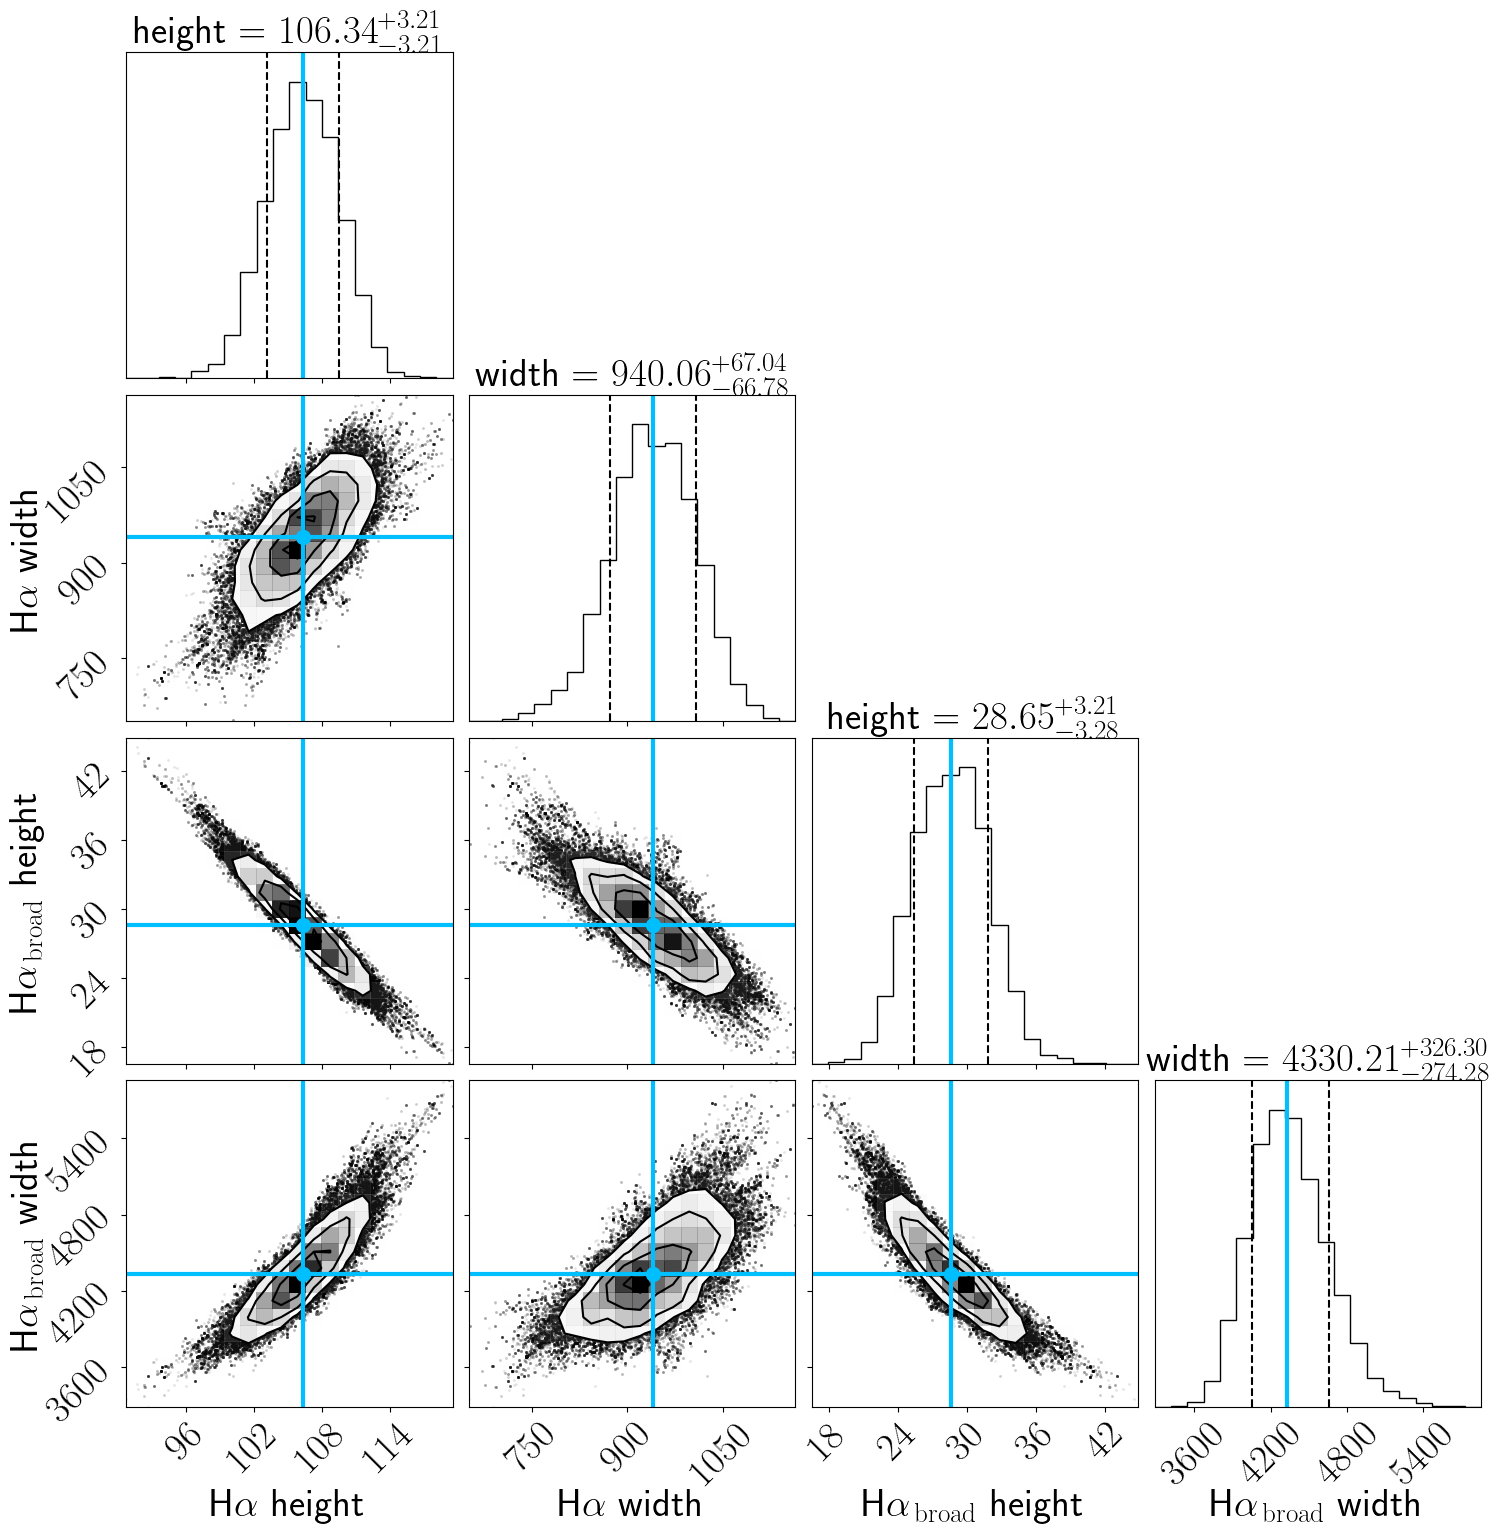

In [137]:
plot_corner(fitnew, fitnew_emcee, req_params=req_cols, save=True, title_names=title_names)